## Прогнозирование стоимости автомобиля по характеристикам
(Проект 8. Возьмёте Бэтмобиль "Skillfactory.ru")  
*DST-55, Перебатов ММ*

<img src="https://www.metaswitch.com/hs-fs/hubfs/assets/images/5g-core-automation-kubernetes-blog.jpg?width=3840&name=5g-core-automation-kubernetes-blog.jpg"  width=1000 />

**Задача**  
Построить модель которая предсказывает цену  автомобиля на основе табличных данных c учетом текстовыx описаний и фотографий. 

**Исходные данные**  
Используем 8353 объявлений(BMW,MERCEDES,AUDI) с сайта auto.ru. Парсинг данных не требуется.  

**Реализация**
В данном ноутбуке я создал и обучил модель на основе классических методов машинного обучения и нейронных сетей (MLP - многослойный перцептрон, RNN - рекурентная нейронная сеть, CNN - сверточная нейронная сеть) для решения задачи регрессии по предсказанию цен на автомибили по объявлениям с сайта auto.ru. 
 
Метрика: MAPE - средняя относительная погрешность. 


## План: 
* Обработка и нормировка признаков с добавлением фичей
* Наивная модель
* Модель на основе градиентного бустинга(CatBoost)
* Простая модель на основе нейронных сетей  
* Multi-input нейронная сеть для анализа табличных данных и текста одновременно
* Модель на основе мультиязычного bert с использованием только описаний   
* multi-input MLP+ NLP + CNN (фото машин)  
* Модель предсказания цены только по картинке(EfficientNetV2M)   
* Ансамбль градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3
#Для CV
!pip install -q albumentations
!pip install -q efficientnet
!pip install -U keras-efficientnet-v2 -q
#Для NLP
!pip install pymystem3
!pip install nltk
!pip install pymorphy3
!pip install pymorphy2-dicts

## Configurations

In [2]:
#Model Params

PATH = './working/'
DATA_PATH = '../input/sf-dst-car-price-prediction-part2/'
N_CLASSES = 5
SEED = 42

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

VAL_SIZE   = 0.15   # 15% для разделения выборки на обучающую и тестовую

## Library

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import pandas_profiling
#ML
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from catboost import CatBoostRegressor
import category_encoders as ce
#DL - MLP+
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.optimizers as O
from tensorflow.keras.models import Model as M, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
#DL - NLP
import pymorphy3
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pymystem3 import Mystem
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

# #DL - CV
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB5, EfficientNetB3
import keras_efficientnet_v2
import efficientnet.tfkeras as efn
import albumentations as a

import re
import PIL
import cv2
import os
import random
import sys
import phik 
from tqdm import tqdm
from string import punctuation

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = (18, 4)
pd.set_option('display.max_columns', 550) # больше колонок

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

In [5]:
!pip freeze > requirements.txt

## Function

In [6]:
def mape(y_true, y_pred):
    '''Функция для вычисления итоговой метрики MAPE(Mean Percentage Absolute Error) '''
    return np.mean(np.abs((y_pred-y_true)/y_true))*100

 
def count_outlier(df_in, col_name):
    '''функция вывода  всех выбросов в список'''
    q25, q75 = np.percentile(df_in[col_name], [25, 75])
    iqr = q75 - q25
    fence_low = q25 - 1.5*iqr
    fence_high = q75 + 1.5*iqr
    return np.where((df_in[col_name] > fence_high) | (df_in[col_name] < fence_low))[0]


def box_and_hist(column, bins, df):
    '''горизонтальный Boxplot + гистограма'''
    fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(10, 4),
                                          sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], ax=ax_box)
    sns.distplot(df[column], ax=ax_hist, bins=bins)
    ax_box.set_title(f'Распределение значений в {column}\n\
                     Выбросов(iqr*1.5) - {len(count_outlier(df, column))}', fontsize=15)

def plot_history(history):
    '''Печать обучения и валидации метрики MAPE и Loss''' 
    acc = history.history['MAPE']
    val_acc = history.history['val_MAPE']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.figure(figsize=(10,8))
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and validation MAPE')
    plt.legend()

#     plt.figure()
#     plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.legend()
    return plt.show()


def predict_to_Kaggle(model,X_test,name='submission'):
    ''' Сохранение результатов на Kaggle.'''
    #Предсказание на test
    Y_pred_test = model.predict(X_test)
    #Пост-обработка - удаление логорифмирования целевого признака
    Y_pred_test = np.exp(Y_pred_test)
    #Создание DF для вывода
    s_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
    s_submission['price'] = Y_pred_test
    #Вывод в файл
    s_submission.to_csv(name+'.csv', index=False)
    pass

def search_word_in_description(description_words = 'Кремль|Бронированный'):
    '''Фильтрация табличных данных по ключевым словам в описании'''
#     description_words = 'индивидуальный заказ|дорогой охранный комплекс|тюнинг|Индивидуальная обивка|апгрейд|красивые номера'
    query = data.description.str.contains(description_words)
    print(f"Найдено {len(data.query('@query==True'))} совпадений")
    return data.query('@query==True').description.sample(2)

def show_table_loss(test_predict, num_loss =5):
    ''' Просмотр  ошибок предсказаний в табличных данных теста'''
    test_loss = pd.DataFrame(test_predict, X_test.index, columns=['predict'])
    loss = ((data['price'] - test_loss["predict"])/1000).round(1)
    data_loss = data.copy()
    data_loss['price'] = (data_loss['price']/1000).round(1)
    data_loss.insert(0, 'price-predict', loss)
    data_loss['abs'] = np.abs(data_loss['price-predict'])
    pd.set_option('display.max_colwidth', 200)
    return data_loss.sort_values('abs', ascending=False).head(num_loss)

def make_callbacks(pat=10, reduce_lr=False):
    '''Обявление колбэков'''
    
    checkpoint = ModelCheckpoint(
        filepath='./best_model.hdf5',
        monitor=['val_MAPE'], 
        verbose=0,
        mode='min'
    )
    earlystop = EarlyStopping(
        monitor='val_MAPE', 
        patience=pat, 
        restore_best_weights=True,
        verbose=1
    )
    if reduce_lr == True:
        reduce_lr = ReduceLROnPlateau(
            monitor='val_MAPE', 
            factor=0.5, 
            min_lr=1e-5, 
            patience=10, 
            verbose=1
        )
        return [checkpoint, earlystop, reduce_lr]
    return [checkpoint, earlystop]


def plot_feature_importance(importance,names, amount=15):
    '''Визуализации важности признаков catboost Classifier, 15 признаков'''
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:amount], y=fi_df['feature_names'][:amount])
    #Add chart labels
    plt.title('CATBOOST FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# DATA

In [7]:
train = pd.read_csv(DATA_PATH+'train.csv')
test = pd.read_csv(DATA_PATH+'test.csv')

sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
# submission = pd.read_csv(DATA_PATH+'sample_submission.csv')

#Пометим датасет
train['sample'] = 1
test['price'] = np.nan
test['sample'] = 0

#Объединим test и train
data = test.append(train, sort=False).reset_index(drop=True) # присвоим новые индексы train начиная с 1671 
print(train.shape, test.shape, data.shape)
data.info()

In [8]:
# Приведём названия всех столбцов к общему типу:
data.rename(columns={'bodyType': 'body_type',
                   'engineDisplacement': 'engine_volume',
                   'enginePower': 'engine_power',
                   'fuelType': 'fuel_type',
                   'modelDate': 'model_date',
                   'numberOfDoors': 'number_of_doors',
                   'productionDate': 'production_date',
                   'vehicleConfiguration': 'vehicle_configuration',
                   'vehicleTransmission': 'vehicle_transmission',
                   'Владельцы': 'owners_qty',
                   'Владение': 'ownership_time',
                   'ПТС': 'licence',
                   'Привод': 'type_of_drive',
                   'Руль': 'steering_wheel',
                   }, inplace=True)

# Отсортируем столбцы для удобства просмотра таблицы с  важным признаками вначале (по моему мнению):
sequence_columns = ['price', 'brand', 'model_info', 'production_date', 'mileage', 'vehicle_transmission', 'name',
            'fuel_type', 'owners_qty', 'description', 'body_type',  'color',  'model_date',
             'engine_power', 'number_of_doors', 'vehicle_configuration','engine_volume',
             'type_of_drive', 'steering_wheel', 'licence', 'ownership_time', 'sell_id', 'sample']

data = data.reindex(columns=sequence_columns)

In [9]:
# data[['description','price']].to_csv('df_description.csv')
pd.set_option('display.max_colwidth', 10)
data.sample(5)

# EDA

In [10]:
data.fuel_type.value_counts()
# ['компактвэн','внедорожник 3 дв.', 'лимузин', 'внедорожник открытый','седан 2 дв.','пикап двойная кабина']

In [11]:
# С помощью ProfileReport создадим статистический отчет по всем признакам. 
# Отчет позволит выявить ошибки, пропуски, дубликаты, высокую корреляцию признаков.
# pandas_profiling.ProfileReport(data)

In [12]:
def preproc_data(data_input, log=True, scaler=True, encoding=True, one_hot=True, add_feature=False):
    '''Подготовка данных для модели
    log - логорифмировать данные
    scaler - нормализация данных MinMax
    encoding - Label Encoding
    one_hot - One-Hot Encoding
    add_feature - плохие фичи'''
    
    data = data_input.copy()
    
    # Оставим только первое число в полях 'owners_qty','engine_power' и переведем их в числовой формат
    for column in ['owners_qty', 'engine_power']:
        data[column] = data[column].astype(str).apply(lambda x: x.split()[0])
        data[column] = data[column].astype(float)

    # Приведём признак engine_volume к строковому типу и  оставим только числовые данные.
    data['engine_volume'] = data['engine_volume'].astype(str)
    data['engine_volume'] = data['engine_volume'].str.extract(
        '(\d.\d)', expand=False).str.strip()
    # Заменим все некорректные числа(объём двигателя в литрах) более 10 на None
    data['engine_volume'] = data['engine_volume'].apply(
        lambda x: None if float(x) > 10 else x).astype(float)

    data['owners_qty'] = data['owners_qty'].fillna(3)  # заполним пропуски
    
    #Подправим значения модели
    data.loc[data['model_info'] == '100', 'model_info'] = 'S4'
    data.loc[data['model_info'] == 'COUPE', 'model_info'] = 'S2'
    data.loc[data['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'
    
    # редкие типы кузова удалим
    data = data.query("(body_type!=['компактвэн','внедорожник 3 дв.', 'лимузин', \
                      'внедорожник открытый','седан 2 дв.','пикап двойная кабина']) or (sample==0)")
    #  удалим гибриды и электрокары
    data = data.query("(fuel_type!=['гибрид','электро']) or (sample==0)")
    
    # =================================================
    #     Feature Engineering
    # ==================================================
    #    1) список дорогих марок, любая из которых продается сейчас выше 5 млн.
    laxury = list(data.query('price>5e6').model_info.value_counts().keys())

    # 2) список марок редко встречающихся в датасете меньше 7 раз.
    rare_model = list(data.model_info.value_counts(ascending=True)[:39].index) 
#     # закодируем
    for value, models in {'laxury': laxury, 'rare_model':rare_model}.items():
        mask = data['model_info'].isin(models)
        data[value] = mask*1
    # 3) новизна модели на момент производства     
    data['model_recency'] = data['production_date'] - data['model_date']
    data['model_recency'] = data['model_recency'].apply(lambda x: 0 if x < 0 else x)
    # 4) cтепень эксплуатации(пробег/год)
    data['mileage_year'] = (data['mileage']/(2020.01 - data['production_date']))
#     # 5) количество символов из описания(description_length)
    data['description_length'] = data['description'].map(lambda x: len(x))
#     # 6) повторяемость объявлений(repeat_description)
    dict_count_description = data['description'].value_counts().loc[lambda x: x > 2].to_dict()
    data['repeat_description'] = data['description'].map(dict_count_description)
    data['repeat_description'].fillna(1, inplace=True)
#     # 7) кто продает машину, автосалон или частное лицо(перекуп).
    auto_dealer = 'тест-драйв|менеджер|клиент|Мы|МЫ|НАШЕМ|мегамолл|АВТОКРЕДИТ|КРЕДИТ|АО|" – официальный дилер"|"- ОФИЦИАЛЬНЫЙ ДИЛЕР"'
    data['auto_dealer'] = data['description'].str.contains(auto_dealer)*1
    data.loc[data['repeat_description']>=3,'auto_dealer'] = 1
#     # 8) проводился ли косметический ремонт.
    auto_repair = 'вмятин|царапин|трещин|скол|притертост'
    data['auto_repair'] = data['description'].str.contains(auto_repair)*1
# #     # 9) в залоге у банка
    pledge_auto = 'Автомобиль находится в залоге|сейчас находится в залоге|залоге у банка'
    data['pledge_auto'] = data['description'].str.contains(pledge_auto)*1

    #==========================    
    #Features которые ухудшают оценку
    #==========================
    if add_feature == True:
    #     10) список спортивных марок(из моделей которые в среднем имеют мощность более 500 л.с.)
        sport = list(data.groupby('model_info').engine_power.mean(
        ).sort_values(ascending=False)[:20].keys())
    #     # 11) тюнинг или индивидуальные доработки.
        auto_tuning = 'индивидуальный заказ|дорогой охранный комплекс|тюнинг|Индивидуальная обивка|апгрейд|красивые номера'
        data['auto_tuning'] = data['description'].str.contains(auto_tuning)*1
    #     # 12) увеличение стоимости из-за коллекционной значимости, известности владельца, бронировании. Слишком мало(кандидаты на выбросы)
        limited_auto = 'коллекционер|Limited Edition|Кремль|Бронированный'
        data['limited_auto'] = data['description'].str.contains(limited_auto)*1

    #     13) Наличие системы xDrive
        data['xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
        data['4WD'] = data['name'].apply(lambda x: 1 if '4WD' in x else 0)

    #==========================
    #    Удаление данных
    #==========================
    # удаляем высоко коррелирующие признаки и "владение_авто" с больши числом пропусков.
    data = data.drop(['model_date', 'name', 'engine_volume',
                        'vehicle_configuration', 'ownership_time', 
                      'description', 'repeat_description', 'sell_id'], axis=1) #engine_volume
    
    cat_features = list(data.select_dtypes(exclude='number').columns)
    #==========================================================
    #     Логорифмирование
    #==========================================================       
    if log == True:
        for column in ['price', 'production_date', 'mileage', 
                       'description_length', 'mileage_year']:#, 'engine_volume'
            data[column] = data[column].apply(np.log)
        
    #===========================================================
    #    Нормализация данных
    #===========================================================
    if scaler == True: 
        num_features = ['mileage', 'production_date', 'engine_power',
                        'model_recency', 'mileage_year', 'description_length']#, 'engine_volume'

        scaler = MinMaxScaler()
        data[num_features] = scaler.fit_transform(data[num_features])

   #==========================================================
   #     Label Encoding
   #==========================================================
    if encoding == True:
        for column in cat_features:
            data[column] = data[column].astype('category').cat.codes
        
   #=========================================================    
   #    One-Hot Encoding: 
   #=========================================================
    if one_hot == True:
        cat_features.remove('licence')
        cat_features.remove('steering_wheel')
        data = pd.get_dummies(data, columns=cat_features, dummy_na=False)
    
    return data

In [13]:
# Теперь выделим тестовую часть
train_data = preproc_data(data.query('sample == 1'), encoding=False, scaler=False, one_hot=False, log=False)
df_train, df_test = train_test_split(train_data, test_size=0.15, shuffle=True, random_state=SEED)

# Посмотрим наибольшие корреляционные связи с  переменной price
all_cols = set(train_data.columns) - set(['price', 'sample'])
correlations = train_data[all_cols]\
    .corrwith(train_data['price']).sort_values(ascending=False)

plt.figure(figsize=(10,5))
plot = sns.barplot(y=correlations.index, x=correlations)

In [14]:

num_cols =  ['price',
 'production_date',
 'mileage',
 'engine_power',
 'model_recency',
 'mileage_year',
 'description_length',
]
for i in num_cols:
    box_and_hist(i, bins=30, df=train_data)

# Итоги:
## В результате EDA:

В приведенном датасете практически нет ошибок.
Более подробный анализ похожих данных был в ноутбуке   
https://www.kaggle.com/mikhailperebatov/perebatovmm-sf-dst48-car-price-prediction-v16б 

**Изменения:**
* Привел признаки для теста и трейна к единой системе кодировок  
* Перевел отдельные признаки к числовому формату  
* Заполнил пустые значения для 1 признака  
* Удалил 3 признака с мультиколлиниарностью(см. картинку ниже) и  с большим числом пропусков. 
* Выбросы не удалялись 
* Прологорифмированы: 'price', 'prodaction_date', 'mileage'

**Добавлены:**  
* Из  описания добавил 5 бинарных признаков  
* Добавил 3 числовых признака на основе описания, пробега, года выпуска  

**Датасет содержит:** 
* 9 числовых признаков (произведена нормализация)  
* 6 категориальных признаков (произведен One-Hot Encoding)  
* 6 бинарных признаков    
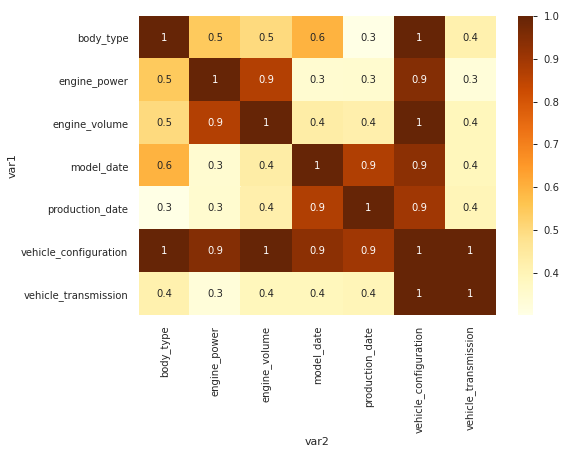


# Model 0: Наивная модель

In [15]:
#Наивная модель
predict = []
for index, row in pd.DataFrame(df_test[['model_info', 'production_date', 'engine_power']]).iterrows():   
    query = f"model_info == '{row[0]}' and production_date  == {row[1]} and engine_power  == {row[2]}"
    if len(df_train.query(query)) == 0: #Если не нашлись совпадения, то заполняем медианным значением даты производства
        query = f"production_date == {row[1]}"
        predict.append(df_train.query(query)['price'].median()) 
    else:  
        predict.append(df_train.query(query)['price'].median())
#Если не нашлись совпадение, то медианным значением
predict = pd.DataFrame(predict)
print(f'Пропусков - {predict.isna().sum()[0]}')
predict = predict.fillna(predict.median())
predict_mape  = mape(df_test['price'], predict.values[:,0])
#Вывод
print(f'Точность наивной модели по метрике MAPE: {predict_mape:.2f}%')


**Точность наивной модели по метрике MAPE: 18.72%**

# Model 1: CatBoostRegressor

In [16]:
# Теперь выделим тестовую часть

df = preproc_data(data, scaler=False, one_hot=False)
y = df.query('sample == 1').price.values     # наш таргет
X = df.query('sample == 1').drop(['sample', 'price'], axis=1)
X_sub = df.query('sample == 0').drop(['sample','price'], axis=1)

cat_features = ['brand', 'model_info', 'vehicle_transmission', 'fuel_type', 
                'body_type', 'color', 'type_of_drive', 'steering_wheel', 'licence']


#Применим HelmertEncoder вместо One_Hot
encoder = ce.HelmertEncoder(cols=cat_features)
X = encoder.fit_transform(X, y)
X_sub = encoder.transform(X_sub)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=SEED)

print(X_train.shape, X_test.shape, X_sub.shape)

#Выгрузим датасет для работы на локальной машине 
# train_data.to_csv("/kaggle/working/train_data.csv")
# test_data.to_csv("/kaggle/working/test_data.csv")

### Grid_search
Подобрал параметры в несколько этапов

In [17]:
'''    cb_model = CatBoostRegressor(**{
    'eval_metric': "MAPE",
    'learning_rate': 0.025,   
    'random_strength': 0.7,          #Процент от выборки для валидации
    'random_seed':SEED,
    })

    grid = {
    'iterations':[5000],
    'learning_rate': [0.025],
    'min_data_in_leaf' : [1, 2, 3],  #Минимальное число прецендентов в лепестке
    'depth': [6],
    'l2_leaf_reg': [0.5, 1, 2]
    }

    grid_search_result = cb_model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train,
                                       cv=3,
                                       plot=True)

    print(grid_search_result['params']) '''
# # В CatBoost удалось подобрать оптимальные параметры для 5000 итераций, 'depth': 6,'learning_rate': 0.025 
# 'l2_leaf_reg': 1, 'min_data_in_leaf' : 1

In [18]:
#Модель - оптимальная по валидационной выборке

model_cbr = CatBoostRegressor(
    iterations = 5000,              #Максимальное число итераций
    learning_rate = 0.025,           #Темп обучения
    l2_leaf_reg = 1.0,                #К-т при регуляризации
    depth = 6,                      #Максимальная глубина деревьев
    min_data_in_leaf = 1,           #Минимальное число прецендентов в лепестке
    random_strength = 0.7,          #Процент от выборки для валидации
    random_seed = SEED,     #Воспроизведение результатов
    eval_metric = 'MAPE',           #Метрика
    od_wait = 250,                   #Количество итераций после достижения оптимума
#     cat_features = cat_features
)

#Обучение
model_cbr.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose_eval=10,
    use_best_model=True,
)



In [19]:
# оцениваем точность
train_predict = np.exp(model_cbr.predict(X_train))
test_predict_cbr = np.exp(model_cbr.predict(X_test))
print(f'train MAPE: {mape(np.exp(y_train), train_predict):0.2f}%,\
 test MAPE: {mape(np.exp(y_test),test_predict_cbr):0.2f}%')

##### **Результаты CatBoostRegressor:**
1) train MAPE: 6.320%, test MAPE: 11.318%.  
2) train MAPE: 6.332%, test MAPE: 11.366%. submission:11.5315   test_size=0.05  
3) train MAPE: 9.427%, test MAPE: 14.248%.                      добавил фичи тюнинг и limited  
4) train MAPE: 7.391%, test MAPE: 11.530%.                      подобрал гиперпараметры  
5) train MAPE: 6.949%, test MAPE: 11.443%.                      убрал фичи тюнинг и limited на подобранных параметрах  
6) train MAPE: 6.384%, test MAPE: 11.257% submission: 11.65171% подобрал гиперпараметры 2, убрал limited, tuning  
7) train MAPE: 7.476%, test MAPE: 11.285%.                      убрал фичу царапины  
8) train MAPE: 6.760%, test MAPE: 11.352%.                      добавил фичи limited  
9) train MAPE: 6.268%, test MAPE: 11.281%.                      убрал фичу редкая модель  
10) train MAPE: 7.277%, test MAPE: 11.392%.                     без фичи в залоге  
11) train MAPE: 6.384%, test MAPE: 11.257%                      добавил фичу в залоге  
12) train MAPE: 6.384%, test MAPE: 11.257%. submission: 11.651  
13) train MAPE: 9.161%, test MAPE: 13.885%.                     без log, oneHot, нормализации  
14) train MAPE: 6.397%, test MAPE: 11.345%. submission: 11.651  + Xdrive  
15) train MAPE: 7.339%, test MAPE: 11.289%.                     + Xdrive и 4WD  
16) train MAPE: 6.33%,  test MAPE: 11.31%  
17) train MAPE: 7.48%, test MAPE: 11.24%                        +engine_volume  
18) train MAPE: 6.50%, test MAPE: 11.13% submission:11.78525    + Xdrive  
19) train MAPE: 6.89%, test MAPE: 11.14%                        + encoder HelmertEncoder  
20) train MAPE: 6.79%, test MAPE: 10.73%                        удалил редкие типы кузовов  
22) train MAPE: 6.40%, test MAPE: 10.57%                        удалил электрокары и гибриды  
**Точность модели №1 по метрике MAPE, submission 11.53%**

In [20]:
dict_res = model_cbr.evals_result_
df_res = pd.DataFrame({'trn':dict_res['learn']['MAPE'],'val':dict_res['validation']['MAPE']}) * 100
#График
df_res.plot(figsize=(10,5))

Посмотрим где модель ошибается и какие признаки важны для Catboost

In [21]:
show_table_loss(test_predict_cbr, 1)

In [22]:
plot_feature_importance(model_cbr.get_feature_importance(),X_train.columns)

### Submission

In [23]:
sample_submission = predict_to_Kaggle(model_cbr,X_sub,name='submission_cb10')
model_cbr.save_model('catboost_model.hdf5')
sub_predict_catboost = np.exp(model_cbr.predict(X_sub))

# Model 3: Tabular NN1

In [24]:
# Теперь выделим тестовую часть

df = preproc_data(data)
y = df.query('sample == 1').price.values     # наш таргет
X = df.query('sample == 1').drop(['sample', 'price'], axis=1)
X_sub = df.query('sample == 0').drop(['sample','price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=SEED)

print(X_train.shape, X_test.shape, X_sub.shape)

## Simple Dense NN

In [25]:
tf.keras.backend.clear_session()

In [26]:
#Формирование модели - оптимальной
model_nn_simple = Sequential()
#Первый слой
model_nn_simple.add(L.Dense(512, input_dim=X_train.shape[1], activation='relu'))
model_nn_simple.add(L.BatchNormalization())
model_nn_simple.add(L.Dropout(0.35, seed=SEED))
#Второй слой
model_nn_simple.add(L.Dense(256, activation='relu'))
model_nn_simple.add(L.BatchNormalization())
model_nn_simple.add(L.Dropout(0.5, seed=SEED))
#Третий слой
model_nn_simple.add(L.Dense(128, activation='relu'))
model_nn_simple.add(L.BatchNormalization())
model_nn_simple.add(L.Dropout(0.5, seed=SEED))
#Четвертый слой
model_nn_simple.add(L.Dense(1, activation='linear'))
#Информация о собранной модели
model_nn_simple.summary()


In [27]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.011)
model_nn_simple.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [28]:
callbacks_list = make_callbacks(pat=100)

### Fit

In [29]:
history = model_nn_simple.fit(X_train, y_train,
                    batch_size=300,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
#                     callbacks=callbacks_list,
                    verbose=1
                   )

In [30]:
test_predict_nn1 = np.exp(model_nn_simple.predict(X_test))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_nn1[:,0])):0.2f}%")

In [31]:
plot_history(history)

Посмотрим где модель ошибается

In [32]:
show_table_loss(test_predict_nn1, 1)

In [33]:
sample_submission = predict_to_Kaggle(model_nn_simple,X_sub,name='submission_nn2')
model_nn_simple.save('../working/model_nn_simple.hdf5')
sub_predict_nn1 = np.exp(model_nn_simple.predict(X_sub))

**Результаты Simple Dense NN1:**  
TEST mape: 14.72% submission 17.23487%  baiseline model  
TEST mape: 19.56% добавил параметры для Коллбэков  
TEST mape: 11.40% добавил BatchNorm и 4 слой, уменьшил dropout на первом слое (0,35)  
TEST mape: 11.37% submission 11.91786% уменьшил batch_size до 300   
TEST mape: 11.20% submission **11.78664%** увеличил lerning_rate до 0.011   
TEST mape: 11.47% удалил записи с редко-встречаемым типом кузова.


## Model 4: Multiple Inputs(MLP + NLP)

In [38]:
# Теперь выделим тестовую часть

df = preproc_data(data)
y = df.query('sample == 1').price.values     # наш таргет
X = df.query('sample == 1').drop(['sample', 'price'], axis=1)
X_sub = df.query('sample == 0').drop(['sample','price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)

print(X_train.shape, X_test.shape, X_sub.shape)

In [39]:
#Функция с лемматизацией и очисткой текста

#Загрузим морфологический анализатор
morph = pymorphy3.MorphAnalyzer()

#Загрузим список русских стоп-слов (nltk):
russian_stopwords = stopwords.words("russian") 


patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-–»«•∙·✔➥●☛“”°№₽²®▼]+"
#если провести анализ в pandas_profiling остается еще куча редких символов: ❗️❤️😉😊🎶🎁🔥👆
# patterns_emo = re.compile("["
#                        u"\U0001F600-\U0001F64F"  # emoticons
#                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                        u"\U00002702-\U000027B0"
#                        u"\U000024C2-\U0001F251"
#                        u"\U0001f926-\U0001f937"
#                        u"\u200d"
#                        u"\u2640-\u2642" 
#                        "]+", flags=re.UNICODE)


def lemmatize(doc):
    '''лемматизации текста'''
    text = doc.lower()  # понижаем регистр
    text = re.sub(patterns, ' ', text)  # удаляем символы из паттерна
#     text = re.sub(patterns_emo, ' ', text) # удаляем смайлики
    strings = []  # создаем массив, в котором будут храниться лемматизированные строки
    for word in text.split():  # берем слово, символ из строки
#         if word not in russian_stopwords: #удалим предлоги и мусорные слова по версии stopwords
        word = word.strip()  # убираем пробелы до и после слова
        word = morph.normal_forms(word)[0]  # приводим к нормальной форме
        strings.append(word)
    return ' '.join(strings)  # вернем значения, разделив пробелами

In [40]:
# Применим функцию к нашему датасету:
data['description_norm'] = data.apply(
    lambda data: lemmatize(data.description), axis=1)

In [41]:
# split данных
text_train = data['description_norm'].iloc[X_train.index]
text_test = data['description_norm'].iloc[X_test.index]
text_sub = data['description_norm'].iloc[X_sub.index]

### Tokenizer

In [42]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data['description_norm'])

In [43]:
# посмотрим слова встречающиеся один раз(в основном опечатки) в словаре tokenize
word_elements = dict(tokenize.word_counts)

word_uniq = []
for key, val in word_elements.items():
    if val == 1:
        word_uniq.append(key)
print(word_uniq[:100])

В описании встречается множество опечаток что увеличивает словарь слов.  
Поиски библиотеки для исправления опечаток руских слов не принесли результатов.

In [44]:
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

In [45]:
# вот так теперь выглядит наш текст
print(text_train.iloc[0])
print(text_train_sequences[0])

### RNN NLP

In [57]:
tf.keras.backend.clear_session()

In [58]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [59]:
#Формирование модели - оптимальной
model_mlp = Sequential()
#Первый слой
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation='relu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.35, seed=SEED))
#Второй слой
model_mlp.add(L.Dense(256, activation='relu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5, seed=SEED))
#Третий слой
model_mlp.add(L.Dense(128, activation='relu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5, seed=SEED))


### Multiple Inputs NN

In [60]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model_mlp_nlp = M(inputs=[model_nlp.input, model_mlp.input], outputs=head)
model_mlp_nlp.summary()

### Fit

In [61]:
optimizer = tf.keras.optimizers.Adam(0.011)
model_mlp_nlp.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
callbacks_list = make_callbacks(pat=70)

In [62]:
history = model_mlp_nlp.fit(
                    [text_train_sequences, X_train], y_train,
                    batch_size=300,
                    epochs=100, # 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

In [63]:
plot_history(history)

In [64]:

model_mlp_nlp.load_weights('../working/best_model.hdf5')
# model_mlp_nlp.save('../working/nn_mlp_nlp.hdf5')

In [65]:

test_predict_nn2 = np.exp(model_mlp_nlp.predict([text_test_sequences, X_test]))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_nn2[:,0])):0.2f}%")

**Результаты NLP + MLP:**  
TEST mape: 11.98% submision 12.52%  
TEST mape: 12.39%  убрал из текста эмодзи  
TEST mape: 11.46% вернул обратно  в описание эмодзи и русские стоп-слова  
TEST mape: 11.57% уменьшил гиперпараметры  batch_size=300,   
TEST mape: 53.09%  Попробовал предобучить NLP используя только описаниие (LSTM) 200 эпох.  
TEST mape: 11.59%  NLP с предобучеными весами  + MLP  
TEST mape: 16.12% 


**Submission**

In [66]:
sub_predict_nn2 = model_mlp_nlp.predict([text_sub_sequences, X_sub])
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sample_submission['price'] = np.exp(sub_predict_nn2[:,0])
sample_submission.to_csv('nn2_submission.csv', index=False)

**Выводы:**
* Модель не улучшилась с добавлением векторизованных призноков из описания машины.
* Удаление стоп-слов, эмодзи также ухудшали оценку
* После обучения модели только на описании, где ничего не было угадано у меня возникли большие сомнения  
что описание вносит хоть какой-то вклад в улучшение. А с учетом фичей которые я вытащил из описания, совершено бесполезно.

* Нужно поработать над алгоритмами очистки и аугментации текста, убрать опечатки.

# Model ?: BERT
Обучить модель не удалось. Сначала столкнулся с проблемой токенизации.   
Перешел в Colab. На обучении возникли ошибки с которыми не смог разобраться.

In [ ]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.initializers import TruncatedNormal

In [ ]:
df_bert = data[['description','price','sample']].copy()
df_bert['price'] = np.log(df_bert['price'])
# df_NLP.to_csv('df_NLP.csv')
# from IPython.display import FileLink
# FileLink(r'df_NLP.csv')

y_bert = df_bert.query('sample == 1').price.values     # наш таргет
X_bert = df_bert.query('sample == 1').drop(['sample', 'price'], axis=1)
X_sub_bert = df_bert.query('sample == 0').drop(['sample','price'], axis=1)

print(X_bert.shape, y_bert.shape, X_sub_bert.shape)

#токенизация не понадобилась, так как пользовался встроенным токенизатором BERTа

In [ ]:
# Задаем модель,  берем мультиязычную модель так как в описании полно английских слов.
model_name = 'bert-base-multilingual-cased'
# model_name = 'bert-base-uncased'

# Максимальное количество слов
MAX_WORDS = 100000
# Максимальная длинная токенов
MAX_SEQUENCE_LENGTH = 256

# загружаем настройки и устанавливаем output_hidden_states - False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Грузим бертовский токенизатор
tokenizer_bert = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Грузим модель
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

In [ ]:
# Грузим основной слой
bert = transformer_model.layers[0]

# Выстраиваем входные данные
input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Грузим бертовскую модель как слой кераса
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Выстраиваем выходные данные
price = Dense(units=1, activation="linear",
              kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
              name='price')(pooled_output)

outputs = {'price': price}

model_bert = M(inputs=inputs, outputs=outputs)

model_bert.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
model_bert.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
# !pip install  transformers -U
# !pip show transformers

In [ ]:
# # Токенизируем входные данные
# X_bert = tokenizer_bert(
#     text=X_bert['description'].to_list(),
#     add_special_tokens=True,
#     max_length=MAX_SEQUENCE_LENGTH,
#     truncation=True,
#     padding=True, 
#     return_tensors='tf',
#     return_token_type_ids = False,
#     return_attention_mask = False,
#     verbose = False)
# # TypeError: 'BertTokenizerFast' object is not callable

In [ ]:
# # Пошла родимая
# history = model_bert.fit(  
#     x={'input_ids': X_bert['input_ids']},
#     y={'price': y_bert},
#     callbacks=None,
#     validation_split=0.15,
#     batch_size=300,
#     epochs=10)

# Model 5: Добавляем картинки (MLP + NLP + CNN)


In [67]:
EPOCHS               = 100 
BATCH_SIZE           = 30   
LR                   = 0.011
VAL_SPLIT            = 0.15 
IMG_SIZE_H           = 320
IMG_SIZE_V           = 240
IMG_CHANNELS         = 3
INPUT_SHAPE          = (IMG_SIZE_H, IMG_SIZE_V, IMG_CHANNELS)

In [68]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.head(n = 3)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values
random_image_brand = random_image['brand'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH+'img/img/' + str(path) + '.jpg')
    plt.subplot(1, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.text(-50,1,im.size, fontsize=8, rotation='vertical',
             va='top') #размер картинки
    plt.text(1,1,str(random_image_brand[index]), fontsize=8,
             va='top', color='r') #размер картинки
    plt.axis('off')
    
plt.show()

In [69]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_PATH + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

### Аугментация данных (Albumentations)

In [82]:
### пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = a.Compose([
    a.HorizontalFlip(),
    a.OneOf([
        a.IAAAdditiveGaussianNoise(),
        a.GaussNoise(),
    ], p=0.2),
    a.OneOf([
        a.MotionBlur(p=0.2),
        a.MedianBlur(blur_limit=3, p=0.1),
        a.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    a.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    a.OneOf([
        a.OpticalDistortion(p=0.3),
        a.GridDistortion(p=0.1),
        a.IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    a.OneOf([
        a.CLAHE(clip_limit=2),
        a.IAASharpen(),
        a.IAAEmboss(),
        a.RandomBrightnessContrast(),
    ], p=0.3),
    a.HueSaturationValue(p=0.3),
], p=1)

#пример машины c броней. Понять  что она бронированная сложно, только из описания.
myList = list(X_train.index)
car1 = myList.index(6806)

plt.figure(figsize = (12,8))
for i in range(3):
    img = augmentation(image = images_train[car1])['image']
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [85]:
#Аугментация данных посложнее
augmentation_hard = a.Compose([a.HorizontalFlip(),# разворот по горизонтали
                          a.CLAHE(clip_limit=20.0, tile_grid_size=(11, 41),p=0.1),# световой фильтр
                          a.OneOf([
                              # обрезка фрагмента 520х350 с вероятностю 0,5. Против других машин в кадре и лишнего фона
                                a.CenterCrop(height=150, width=220),
                                ],p=0.5),
                          a.Cutout(always_apply=False, num_holes=10, max_h_size=40, max_w_size=40, p=0.4), #пустые фрагменты на картинке
                        
#                           a.CoarseDropout(max_width=40, max_height=40, p=0.2),#пустые фрагменты на картинке
                          a.Rotate(limit=20, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                          a.OneOf([
                            a.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
                            a.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
                          ],p=0.5),
                          a.GaussianBlur(p=0.05),
                          a.HueSaturationValue(p=0.5),
                          a.RGBShift(p=0.5),
                          a.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
                          a.Resize(IMG_SIZE_V, IMG_SIZE_H)
                          ]) 

#пример  занижения оценки проблемной машины, гелик стоит 15 млн. 
myList = list(X_train.index)
car = myList.index(6002)
print(car)
plt.figure(figsize = (12,8))
for i in range(3):
    img = augmentation_hard(image = images_train[car])['image']
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [86]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation_hard(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
        print('')
    return augmented_images

In [87]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data['description_norm'])

In [88]:
def process_image(image):
    return augmentation_hard(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data['description_norm'].iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data['description_norm'].iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data['description_norm'].iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

**Посмотрим как были подготовлены данные на обучение**

In [91]:
batch_1= next(iter(train_dataset.batch(1)))
plt.figure(figsize=(3,3))
plt.show(plt.imshow(batch_1[0][0][0])) #фото
print(f'Эмбединг таблицы:{batch_1[0][1]}') 
print(f'Эмбединг описания:{batch_1[0][2]}') 
print(f'Цена:{batch_1[1]}')

### Строим сверточную сеть для анализа изображений без "головы"

In [92]:
tf.keras.backend.clear_session()

In [93]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', 
                                                                       include_top = False, 
                                                                       input_shape = (IMG_SIZE_V, IMG_SIZE_H, IMG_CHANNELS))
#Fine Tuning
# efficientnet_model.trainable = True
# fine_tune_at = len(efficientnet_model.layers)//2
# for layer in efficientnet_model.layers[:fine_tune_at]:
#     layer.trainable =  False

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [94]:
#строим нейросеть для анализа табличных данных
#Формирование модели - оптимальной
model_mlp = Sequential([
    #Первый слой
    L.Input(shape=X_train.shape[1]),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dropout(0.35, seed=SEED),
    #Второй слой
    L.Dense(256, activation='relu'),
    L.BatchNormalization(),
    L.Dropout(0.5, seed=SEED),
    #Третий слой
    L.Dense(128, activation='relu'),
    L.BatchNormalization(),
    L.Dropout(0.5, seed=SEED)
    ])


In [95]:
nlp_model = Sequential([
    #Первый слой
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(),
    #Второй слой
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    #Третий слой
    L.Dense(128, activation = 'sigmoid'),
    L.LSTM(64),
    L.Dropout(0.25),
    #Четвертый слой
    L.Dense(64),
    ])

In [ ]:
# загрузим веса уже обученных моделей из предыдущего раздела
# model_mlp.load_weights('./model_nn_simple.hdf5')

In [96]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, model_mlp.output, nlp_model.output])

# добавлям голову для лог. регресси
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = M(inputs=[efficientnet_model.input, model_mlp.input, nlp_model.input], outputs=head)
model.summary()

In [99]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [100]:
callbacks_list = callbacks_list = make_callbacks(pat=10, reduce_lr=False)

In [101]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [102]:
plot_history(history)

In [ ]:
model.load_weights('../working/best_model.hdf5')
# model.save('../working/nn_final.hdf5')

In [103]:
test_predict_final = np.exp(model.predict(test_dataset.batch(30)))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_final[:,0])):0.2f}%")

**Результаты NLP + MLP + CNN:**  
TEST mape: 57.28% - learning rate 0.01, 10 эпох. Что то пошло не так  
TEST mape: 15.89% - learning rate 0.005,  early stopping сработал на 33 эпохе.  продолжил обучение  
TEST mape: 19.33% - learning rate 0.005, продолжил обучение но с более простыми аугментациями, early stopping сработал на 44 эпохе.   
TEST mape: 15.85% - baseline простые аугментации early stopping сработал на 23 эпохе
TEST mape: 14.89% - learning rate 0.005 aug_hard, early stopping сработал на 23 эпохе

In [ ]:
# show_table_loss(test_predict_final, 5)

**Submission**

In [104]:
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sub_predict_final = np.exp(model.predict(sub_dataset.batch(30)))
sample_submission['price'] = sub_predict_final[:,0]
sample_submission.to_csv('submission_final.csv', index=False)


# Model 6: Только фото (CNN)

In [ ]:
#Времени не хватило сделать проще генератор
def process_image(image):
    return augmentation_hard(image = image.numpy())['image']


def tf_process_train_dataset_element_cnn(image, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return (image), price

def tf_process_val_dataset_element_cnn(image, price):
    return (image), price

train_dataset_cnn = tf.data.Dataset.from_tensor_slices((
    images_train, y_train
    )).map(tf_process_train_dataset_element_cnn)

test_dataset_cnn = tf.data.Dataset.from_tensor_slices((
    images_test, y_test
    )).map(tf_process_val_dataset_element_cnn)

y_sub_cnn = np.zeros(len(X_sub))
sub_dataset_cnn = tf.data.Dataset.from_tensor_slices((
    images_sub, y_sub_cnn
    )).map(tf_process_val_dataset_element_cnn)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset_cnn.__iter__().__next__();
test_dataset_cnn.__iter__().__next__();
sub_dataset_cnn.__iter__().__next__();

In [ ]:
batch_1= next(iter(train_dataset_cnn.batch(1)))
plt.show(plt.imshow(batch_1[0][0])) #фото
print(f'Цена:{batch_1[1]}')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# https://github.com/leondgarse/Keras_efficientnet_v2
base_model = keras_efficientnet_v2.EfficientNetV2M(input_shape=INPUT_SHAPE, drop_connect_rate=0.2, num_classes=0, pretrained="imagenet21k-ft1k")
base_model.trainable = True

fine_tune_at = len(base_model.layers)//2
for layer in efficientnet_model.layers[fine_tune_at-1:]:
    layer.trainable =  False

# Прикрутим новую голову
model_cnn = Sequential()
model_cnn.add(base_model)

# Добавим пулинг слой
model_cnn.add(L.GlobalAveragePooling2D())

# Новая голова на предсказание цены
model_cnn.add(Dense(1, activation='linear'))

# Тренируем
optimizer = tf.keras.optimizers.Adam(0.001)
model_cnn.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

model_cnn.summary()

In [ ]:
history = model_cnn.fit(train_dataset_cnn.batch(5),
                    epochs=10,
                    validation_data = test_dataset_cnn.batch(5),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model_cnn.load_weights('../working/best_model.hdf5')
model_cnn.save('../working/model_cnn.hdf5')

In [ ]:
test_predict_cnn = np.exp(model_cnn.predict(test_dataset_cnn.batch(5)))
print(f"TEST mape: {mape(np.exp(y_test), test_predict_cnn[:,0]):0.2f}%")

**Результаты CNN:**  
TEST mape: 48.86% Возможно больше эпох улучшат результат, модель сильно недооценивает машины.

In [ ]:
# show_table_loss(test_predict_cnn, 40)

In [ ]:
# sub_predict_cnn = np.exp(model_cnn.predict(sub_dataset_cnn.batch(5)))
# sample_submission['price'] = sub_predict_cnn[:,0]
# sample_submission.to_csv('submission_cnn.csv', index=False)

# 7. Blend

In [35]:
#Catboost и Simple NN
for q in np.linspace(0.05,0.5,10):
    q2 = 1 - q
    blend_predict_1 = (q2 * test_predict_cbr + q * test_predict_nn1[:,0])
    print(f"TEST mape: {round(q2,2), round(q,2) }-{(mape(np.exp(y_test), blend_predict_1)):0.2f}%")
#     Лучший вариант (0.75, 0.25)-10.23%

In [105]:
#Catboost и MLP+NLP+CNN
for q in np.linspace(0.05,0.5,10):
    q2 = 1 - q
    blend_predict_2 = (q2 * test_predict_cbr + q * test_predict_final[:,0])
    print(f"TEST mape: {round(q2,2), round(q,2) }-{(mape(np.exp(y_test), blend_predict_2)):0.2f}%")
#     Лучший вариант (0.95, 0.05)-10.48%

**Submission final**

In [37]:
#Blend CatBoost и MLP
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
blend_sub_predict = (0.75 * sub_predict_catboost + 0.25 * sub_predict_nn1[:,0])  #sub_predict_final
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)


In [107]:
# Blend CatBoost и MLP_NLP_CNN
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
blend_sub_predict = (0.95 * sub_predict_catboost + 0.05 * sub_predict_final[:,0])  #sub_predict_final
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submissionf.csv', index=False)

# 8. Results  


**Выполнено:**
* Анализ данных
* Предобработка данных:
    * приведение кодировок к единому формату, заменены ошибки
    * проведено логарифмирование признаков и нормализация
    * удалены записи с специфичными автомобилями (электрокары, лимузины)
    * подготовлены дополнительные признаки из описания и комбинации числовых
    * часть признаков удалена, на основе анализа корреляции
    * была произведена лемматизация текста в признаке 'description' с последующей и токенизацией
    * Label Encoding, One-Hot Encoding, HelmertEncoder  
* проверено несколько вариантов архитектуры сети для обработки табличных данных
* настройка callback
* опробованы архитектуры сети для обработки текстовых данных, в том числе мультиязычный BERT
* применены сложные и простые аугментации на основе библиотеки albumentation
* обучение изображений на  основе сетей EfficientNetB3, EfficientNetV2M
* Multi-input нейронная сеть для анализа табличных данных, текста и фотографий одновременно
* несколько вариантов ансамблей моделей

**Итоги обучения:**
* CatBoost---------------------10.53%
* MLP--------------------------11.47%
* MLP + NLP--------------------16.12%
* MLP + NLP + CNN--------------17.19%
* NLP--------------------------53.09%
* CNN--------------------------48.86%
* Blend CatBoost и MLP---------10.23%
* Blend CatBoost и MLP_NLP_CNN-12.48%

Метрика  MAPE ,на соревновании kaggle равна 11.18687 % (40-е место).
    
Основной упор делал на CatBoost с извлечением фичей из текста.  
Результатами обработки текста был не удовлетворен, и по моему мнению пользы нейронная сеть не приносила. К сожалению применит Bert не удалось. 
Сверточные сети на основе анализа фотографий дают небольшое улучшение, но обучить модель должным образом не успел.

**Что не было выполнено - идеи для улучшения моделей:**
* Поработать с текстом, заменить опечатки, выделить словосочетания, добавить аугментации текста, BERT